In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [5]:
import os
os.chdir('/content')


In [6]:
import requests
import os
import zipfile
from tqdm import tqdm

def download_file(url, filename):
    """
    Downloads a file from a URL to the specified filename with a progress bar.

    Args:
        url (str): URL of the file to download
        filename (str): Local path where the file should be saved

    Returns:
        bool: True if download successful, False otherwise
    """
    # Check if file already exists
    if os.path.exists(filename):
        print(f"File {filename} already exists. Skipping download.")
        return True

    try:
        # Note: Consider enabling SSL verification in production environments
        response = requests.get(url, stream=True, verify=False)
        response.raise_for_status()  # Raise an exception for HTTP errors

        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(filename, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR: Download incomplete. File may be corrupted.")
            return False

        return True
    except requests.exceptions.RequestException as e:
        print(f"ERROR: Download failed: {e}")
        return False

def extract_zip(zip_path, extract_path):
    """
    Extracts a zip file to the specified path.

    Args:
        zip_path (str): Path to the zip file
        extract_path (str): Path where contents should be extracted

    Returns:
        bool: True if extraction successful, False otherwise
    """
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        return True
    except zipfile.BadZipFile:
        print(f"ERROR: {zip_path} is not a valid zip file.")
        return False
    except Exception as e:
        print(f"ERROR: Failed to extract zip file: {e}")
        return False

def prepare_dataset(dataset_url, download_path, extract_path):
    """
    Downloads and extracts the dataset if not already present.

    Args:
        dataset_url (str): URL to download the dataset from
        download_path (str): Path where the dataset will be downloaded
        extract_path (str): Path where the dataset will be extracted

    Returns:
        bool: True if dataset is ready for use, False otherwise
    """
    # Ensure directories exist
    os.makedirs(os.path.dirname(download_path), exist_ok=True)

    # Download the dataset
    if not os.path.exists(download_path):
        print(f"Downloading dataset from {dataset_url}...")
        if not download_file(dataset_url, download_path):
            return False
        print(f"Dataset downloaded to: {download_path}")

    # Extract the dataset
    if not os.path.exists(extract_path):
        print(f"Extracting dataset to {extract_path}...")
        if not extract_zip(download_path, os.path.dirname(extract_path)):
            return False
        print("Extraction complete.")
    else:
        print("Dataset already extracted. Skipping extraction.")

    return True

In [7]:

# Download and prepare the TinyVIRAT-v2 dataset
DATASET_URL = 'https://www.crcv.ucf.edu/tiny-actions-challenge-cvpr2021/data/TinyVIRAT-v2.zip'
DOWNLOAD_PATH = '/content/datasets/TinyVIRAT-v2.zip'
EXTRACT_PATH = '/content/datasets/TinyVIRAT_V2'

# Execute the dataset preparation
dataset_ready = prepare_dataset(DATASET_URL, DOWNLOAD_PATH, EXTRACT_PATH)

if dataset_ready:
    print("Dataset is ready for use!")
else:
    print("Failed to prepare dataset. Please check the errors above.")

Dataset already extracted. Skipping extraction.
Dataset is ready for use!


In [8]:
!pip install torch torchvision torchaudio tqdm transformers opencv-python decord pytorchvideo scikit-learn tensorboard --quiet


In [47]:
from train import main
# main() # uncomment for training

Text logs configured to be saved to: outputs/R2plus1D_Torchvision_Run3_log.txt


# EVALUATION

### Model Loading

In [11]:
import torch
import sys
sys.path.append('.')
import config as cfg
from inference import load_inference_model, load_class_map, preprocess_video

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_inference_model('/content/drive/MyDrive/SurveillanceActionRecognition/outputs/R2plus1D_Torchvision_Run3/best_model.pth', device)
class_map = load_class_map()
print('Model and class map loaded.')

Generating model structure for inference (pretrained weights will be loaded from checkpoint)...
Generating torchvision model: r2plus1d_18
Loading model with random weights.
Original classifier input features: 512
Replaced final classifier (fc) with 512 input features and 9 output classes (from config.py).
Loading trained weights from checkpoint: /content/drive/MyDrive/SurveillanceActionRecognition/outputs/R2plus1D_Torchvision_Run3/best_model.pth
Trained model loaded successfully for inference.
Model and class map loaded.


## Check model size

In [ ]:
model_path = '/content/drive/MyDrive/SurveillanceActionRecognition/outputs/R2plus1D_Torchvision_Run3/best_model.pth'
assert os.path.exists(model_path), f"Model file not found: {model_path}"
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"Model file size: {model_size_mb:.2f} MB")
if model_size_mb <= 500:
    print('✅ Model size requirement met.')
else:
    print('❌ Model size exceeds 500 MB!')

Model file size: 358.52 MB
✅ Model size requirement met.


In [ ]:
import torch
import torchvision.transforms.v2 as transforms
from decord import VideoReader, cpu, DECORDError
import numpy as np
import os
import traceback 

def preprocess_clip_decord(video_path, clip_length, input_size, norm_mean, norm_std, device):
    try:
        vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
        total_frames = len(vr)

        if total_frames < clip_length:
            del vr
            return None

        start_index = max(0, (total_frames - clip_length) // 2)
        frame_indices = list(range(start_index, start_index + clip_length))
        frame_indices = [min(idx, total_frames - 1) for idx in frame_indices]

        frames_np = vr.get_batch(frame_indices).asnumpy()
        del vr 

        if frames_np.shape[0] != clip_length:
             print(f"  ERROR: Frame count mismatch for {os.path.basename(video_path)}. Read {frames_np.shape[0]}, expected {clip_length}.")
             return None

        frames_tensor = torch.from_numpy(frames_np)

        transform = transforms.Compose([
            transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)), # T,H,W,C -> T,C,H,W
            transforms.ConvertImageDtype(torch.float32),
            transforms.Resize((input_size, input_size), antialias=True),
            transforms.Normalize(mean=norm_mean, std=norm_std),
            transforms.Lambda(lambda x: x.permute(1, 0, 2, 3)) # T,C,H,W -> C,T,H,W
        ])
        processed_tensor = transform(frames_tensor)

        final_tensor = processed_tensor.unsqueeze(0).to(device)

        return final_tensor

    except DECORDError as e:
        print(f"  ERROR: DECORDError processing {os.path.basename(video_path)}: {e}")
        return None
    except Exception as e:
        print(f"  ERROR: Exception during decord preprocessing for {os.path.basename(video_path)}:")
        traceback.print_exc()
        return None

In [ ]:
# select 10 random samples and show size, length, FPS, etc

import glob
import random
import os   
import cv2  
import numpy as np 

def format_size(size_bytes):
    if size_bytes == 0:
       return "0 B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(np.floor(np.log(size_bytes) / np.log(1024)))
    p = np.power(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

test_videos_dir = '/content/datasets/large_videos_2' 
video_files_all = sorted(glob.glob(os.path.join(test_videos_dir, '*.mp4')))
assert len(video_files_all) >= 20, f"Not enough .mp4 videos found in {test_videos_dir} (found {len(video_files_all)})"
video_files = random.sample(video_files_all, 10)
print(f"Randomly selected {len(video_files)} videos for evaluation:")
print("-" * 30)

for video_path in video_files:
    print(f"Video: {os.path.basename(video_path)}") 

    try:
        file_size_bytes = os.path.getsize(video_path)
        print(f"  - Size: {format_size(file_size_bytes)}")

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("  - Error: Could not open video file with OpenCV.")
            print("-" * 30)
            continue 

        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        duration_sec = 0.0
        duration_str = "N/A"
        if fps and fps > 0 and frame_count and frame_count >= 0:
            duration_sec = frame_count / fps
            duration_str = f"{duration_sec:.2f} s"
        elif frame_count == 0:
             duration_str = "0.00 s (0 frames)"

        fps_str = f"{fps:.2f}" if fps and fps > 0 else "N/A"

        print(f"  - Resolution: {width}x{height}")
        print(f"  - Frame Rate: {fps_str} FPS")
        print(f"  - Length: {duration_str} ({frame_count} frames)")

        cap.release() 

    except FileNotFoundError:
        print(f"  - Error: File not found at {video_path}")
    except Exception as e:
        print(f"  - An unexpected error occurred: {e}")
        if 'cap' in locals() and cap.isOpened():
            cap.release()

    print("-" * 30) 

Randomly selected 10 videos for evaluation:
------------------------------
Video: caviar_ShopAssistant1front.mp4
  - Size: 894.67 KB
  - Resolution: 384x288
  - Frame Rate: 25.00 FPS
  - Length: 67.04 s (1676 frames)
------------------------------
Video: ucaerial_actions3_Walking_2_11.mp4
  - Size: 49.99 KB
  - Resolution: 634x596
  - Frame Rate: 23.00 FPS
  - Length: 0.26 s (6 frames)
------------------------------
Video: ucaerial_actions3_Walking_2_1.mp4
  - Size: 113.99 KB
  - Resolution: 634x596
  - Frame Rate: 23.00 FPS
  - Length: 0.70 s (16 frames)
------------------------------
Video: caviar_ShopAssistant2front.mp4
  - Size: 2.18 MB
  - Resolution: 384x288
  - Frame Rate: 25.00 FPS
  - Length: 148.04 s (3701 frames)
------------------------------
Video: caviar_OneStopNoEnter1cor.mp4
  - Size: 400.17 KB
  - Resolution: 384x288
  - Frame Rate: 25.00 FPS
  - Length: 29.04 s (726 frames)
------------------------------
Video: caviar_OneStopMoveNoEnter1cor.mp4
  - Size: 790.54 KB
  -

In [ ]:

import gc
import time
import os 
import numpy as np
import torch
from decord import VideoReader, cpu, DECORDError
import torchvision.transforms.v2 as transforms
from functools import partial
import traceback 

NUM_REPEATS_PER_VIDEO = 10  
WARMUP_RUNS = 3             
STRIDE = 1                  

CLIP_LENGTH = 16       
INPUT_SIZE = 112    
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]


def preprocess_clip_decord(video_path, clip_length, input_size, norm_mean, norm_std, device):
    try:
        vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
        total_frames = len(vr)

        if total_frames < clip_length:
            del vr
            return None

        start_index = max(0, (total_frames - clip_length) // 2)
        frame_indices = list(range(start_index, start_index + clip_length))
        frame_indices = [min(idx, total_frames - 1) for idx in frame_indices]

        frames_np = vr.get_batch(frame_indices).asnumpy()
        del vr

        if frames_np.shape[0] != clip_length:
             print(f"  ERROR: Frame count mismatch for {os.path.basename(video_path)}. Read {frames_np.shape[0]}, expected {clip_length}.")
             return None 

        frames_tensor = torch.from_numpy(frames_np)

        transform = transforms.Compose([
            transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)), # T,H,W,C -> T,C,H,W
            transforms.ConvertImageDtype(torch.float32),
            transforms.Resize((input_size, input_size), antialias=True),
            transforms.Normalize(mean=norm_mean, std=norm_std),
            transforms.Lambda(lambda x: x.permute(1, 0, 2, 3)) # T,C,H,W -> C,T,H,W
        ])
        processed_tensor = transform(frames_tensor)

        final_tensor = processed_tensor.unsqueeze(0).to(device)
        return final_tensor

    except DECORDError as e:
        print(f"  ERROR: DECORDError processing {os.path.basename(video_path)}: {e}")
        return None
    except Exception as e:
        print(f"  ERROR: Exception during decord preprocessing for {os.path.basename(video_path)}:")
        traceback.print_exc() 
        return None

def measure_granular_latency(model, preprocess_fn, video_path, device, num_repeats=NUM_REPEATS_PER_VIDEO, warmup_runs=WARMUP_RUNS):
    model.eval()
    if torch.cuda.is_available(): torch.cuda.empty_cache() 
    gc.collect()
    # --- Warmup Phase ---
    try:
        for i in range(warmup_runs):
            input_tensor = preprocess_fn(video_path) 
            if input_tensor is None:
                 print(f"  Warning: Preprocessing returned None during warmup {i+1} for {os.path.basename(video_path)}. Skipping video.")
                 return None, None, None 
            with torch.no_grad():
                 _ = model(input_tensor)
        if torch.cuda.is_available(): torch.cuda.synchronize() 
    except Exception as e:
        print(f"  Error during warmup for {os.path.basename(video_path)}: {e}")
        traceback.print_exc()
        return None, None, None
    # --- Timed Measurement Phase ---
    prep_h2d_times, inf_times, total_times = [], [], []
    try:
        for i in range(num_repeats):
            if torch.cuda.is_available(): torch.cuda.synchronize()
            start_total = time.perf_counter()

            # --- 1. Preprocessing + H2D Transfer (timed together) ---
            if torch.cuda.is_available(): torch.cuda.synchronize()
            start_prep_h2d = time.perf_counter()
            input_tensor = preprocess_fn(video_path) # Call the wrapped preprocessor
            if torch.cuda.is_available(): torch.cuda.synchronize()
            end_prep_h2d = time.perf_counter()

            if input_tensor is None:
                 print(f"  Warning: Preprocessing returned None during measurement repeat {i+1} for {os.path.basename(video_path)}. Skipping repeat.")
                 continue # Skip this failed repeat

            prep_h2d_times.append(end_prep_h2d - start_prep_h2d)

            # --- 2. Inference ---
            start_inf = time.perf_counter()
            with torch.no_grad():
                _ = model(input_tensor)
            if torch.cuda.is_available(): torch.cuda.synchronize()
            end_inf = time.perf_counter()
            inf_times.append(end_inf - start_inf)

            # --- Total Time End ---
            end_total = time.perf_counter()
            total_times.append(end_total - start_total)

        if not total_times or not prep_h2d_times or not inf_times: # Check if any list is empty
             print(f"  Warning: No successful measurements recorded (Preprocessing failures?) for {os.path.basename(video_path)}.")
             return None, None, None

        # Calculate Averages
        avg_prep_h2d = np.mean(prep_h2d_times)
        avg_inf = np.mean(inf_times)
        avg_total = np.mean(total_times) # Use the separately timed total for consistency

        # Return average times in seconds
        return avg_prep_h2d, avg_inf, avg_total

    except Exception as e:
        print(f"  Error during timed measurement for {os.path.basename(video_path)}: {e}")
        traceback.print_exc()
        return None, None, None

# --- Main Execution ---


if 'video_files' in locals() and isinstance(video_files, list) and video_files:
    preprocessor = partial(preprocess_clip_decord,
                           clip_length=CLIP_LENGTH,
                           input_size=INPUT_SIZE,
                           norm_mean=NORMALIZATION_MEAN,
                           norm_std=NORMALIZATION_STD,
                           device=device)

    print(f"\n--- Starting Granular Latency Evaluation (using decord) on {len(video_files)} videos from CELL1 ---")
    results = []
    for video_path in video_files:
        print(f"\nEvaluating: {os.path.basename(video_path)}")
        avg_prep_h2d_s, avg_inf_s, avg_total_s = measure_granular_latency(
            model=model,
            preprocess_fn=preprocessor,
            video_path=video_path,
            device=device, 
            num_repeats=NUM_REPEATS_PER_VIDEO,
            warmup_runs=WARMUP_RUNS
        )

        if avg_total_s is not None:
            print(f"  Avg Prep+H2D: {avg_prep_h2d_s*1000:.2f} ms | Avg Inference: {avg_inf_s*1000:.2f} ms | Avg Total: {avg_total_s*1000:.2f} ms")
            results.append({
                'video': os.path.basename(video_path),
                'prep_h2d_ms': avg_prep_h2d_s*1000,
                'inf_ms': avg_inf_s*1000,
                'total_ms': avg_total_s*1000
            })
        else:
            print(f"  Skipped or error during evaluation.")

    # --- Final Summary ---
    if results:
        # Calculate statistics
        mean_prep_h2d = np.mean([r['prep_h2d_ms'] for r in results])
        mean_inf = np.mean([r['inf_ms'] for r in results])
        mean_total_ms = np.mean([r['total_ms'] for r in results])
        median_total_ms = np.median([r['total_ms'] for r in results])
        mean_total_s = mean_total_ms / 1000.0 # Convert mean total time to seconds

        # Print summary table
        print(f"\n=== Average Latency Across {len(results)} Videos ===")
        print(f"Mean Prep+H2D Time:      {mean_prep_h2d:.2f} ms")
        print(f"Mean Inference Time:     {mean_inf:.2f} ms")
        print(f"------------------------------------")
        print(f"Mean Total Clip Time:    {mean_total_ms:.2f} ms")
        print(f"Median Total Clip Time:  {median_total_ms:.2f} ms")

        # Print FPS results
        clip_fps = 1.0 / mean_total_s if mean_total_s > 0 else 0
        print(f"\nClip Processing Rate (based on Mean Total Time): {clip_fps:.2f} Clips/Second")

        effective_realtime_fps = STRIDE / mean_total_s if mean_total_s > 0 else 0
        print(f"Effective Real-time FPS (@ Stride={STRIDE}): {effective_realtime_fps:.2f} FPS")
        print(f"(This is the max input video FPS the system can handle with a stride of {STRIDE} frames)")

    else:
        print("\nNo successful evaluations completed.")

else:
    print("Error: 'video_files' list not found. Please ensure CELL1 has been run successfully.")


--- Starting Granular Latency Evaluation (using decord) on 10 videos from CELL1 ---

Evaluating: caviar_ShopAssistant1front.mp4
  Avg Prep+H2D: 59.99 ms | Avg Inference: 9.41 ms | Avg Total: 69.41 ms

Evaluating: ucaerial_actions3_Walking_2_11.mp4
  Skipped or error during evaluation.

Evaluating: ucaerial_actions3_Walking_2_1.mp4
  Avg Prep+H2D: 94.02 ms | Avg Inference: 9.43 ms | Avg Total: 103.47 ms

Evaluating: caviar_ShopAssistant2front.mp4
  Avg Prep+H2D: 72.33 ms | Avg Inference: 9.40 ms | Avg Total: 81.74 ms

Evaluating: caviar_OneStopNoEnter1cor.mp4
  Avg Prep+H2D: 70.81 ms | Avg Inference: 9.43 ms | Avg Total: 80.26 ms

Evaluating: caviar_OneStopMoveNoEnter1cor.mp4
  Avg Prep+H2D: 61.57 ms | Avg Inference: 9.42 ms | Avg Total: 71.00 ms

Evaluating: caviar_TwoEnterShop1cor.mp4
  Avg Prep+H2D: 58.34 ms | Avg Inference: 9.43 ms | Avg Total: 67.78 ms

Evaluating: caviar_OneStopMoveNoEnter1front.mp4
  Avg Prep+H2D: 59.48 ms | Avg Inference: 9.47 ms | Avg Total: 68.96 ms

Evaluati


Generating Stacked Bar Chart...


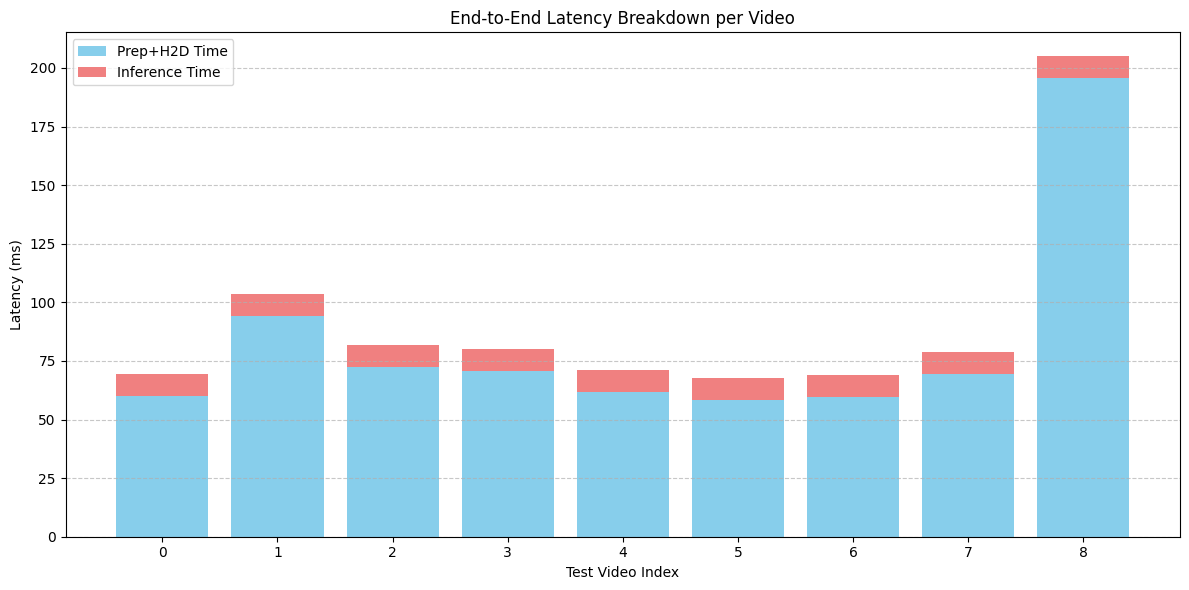


Generating Box Plot...


<ipython-input-46-b3a35db2a85b>:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot.values, labels=data_to_plot.columns, patch_artist=True, notch=False)


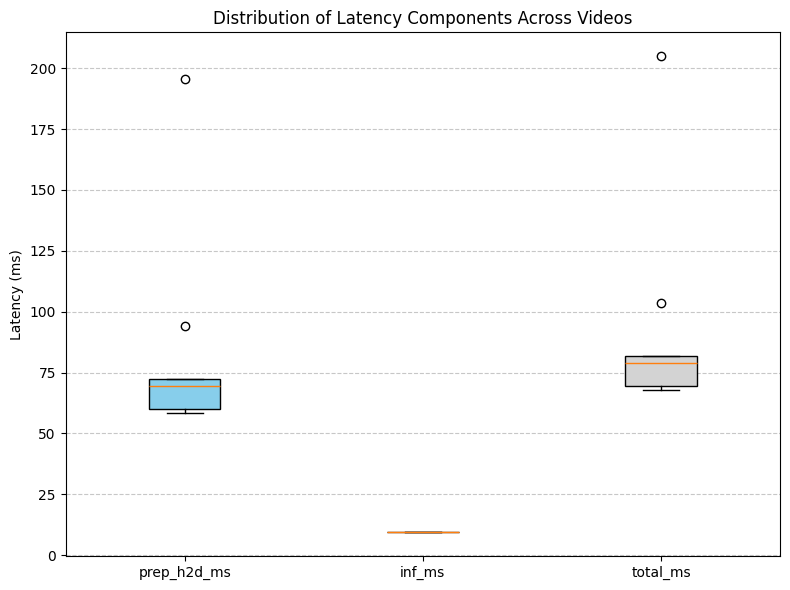

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

if 'results' not in locals() or not isinstance(results, list) or not results:
    print("Error: 'results' list not found or empty. Please run CELL2 successfully first.")
else:

    df = pd.DataFrame(results)

    print("\nGenerating Stacked Bar Chart...")
    fig1, ax1 = plt.subplots(figsize=(12, 6)) 

    video_indices = np.arange(len(df))

    ax1.bar(video_indices, df['prep_h2d_ms'], label='Prep+H2D Time', color='skyblue')
    ax1.bar(video_indices, df['inf_ms'], bottom=df['prep_h2d_ms'], label='Inference Time', color='lightcoral')

    ax1.set_xlabel('Test Video Index')
    ax1.set_ylabel('Latency (ms)')
    ax1.set_title('End-to-End Latency Breakdown per Video')
    ax1.set_xticks(video_indices)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() 
    plt.show()

    print("\nGenerating Box Plot...")
    fig2, ax2 = plt.subplots(figsize=(8, 6))

    data_to_plot = df[['prep_h2d_ms', 'inf_ms', 'total_ms']]

    bp = ax2.boxplot(data_to_plot.values, labels=data_to_plot.columns, patch_artist=True, notch=False)

    colors = ['skyblue', 'lightcoral', 'lightgrey']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax2.set_ylabel('Latency (ms)')
    ax2.set_title('Distribution of Latency Components Across Videos')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Evaluate GPU VRAM Usage

In [44]:
def measure_gpu_memory(model, video_path, device):
    torch.cuda.empty_cache()
    gc.collect()
    input_tensor = preprocess_video(video_path, device=device)
    input_tensor = input_tensor.to(device)
    torch.cuda.reset_peak_memory_stats(device)
    with torch.no_grad():
        _ = model(input_tensor)
    peak_mem = torch.cuda.max_memory_allocated(device) / 1e9  # GB
    return peak_mem

peak_mems = []
if torch.cuda.is_available():
    for video_path in video_files:
        print(f"Measuring GPU memory for: {os.path.basename(video_path)}")
        peak_mem = measure_gpu_memory(model, video_path, device)
        print(f"  Peak GPU memory: {peak_mem:.2f} GB")
        peak_mems.append(peak_mem)
    max_peak_mem = np.max(peak_mems)
    print(f"\nMax peak GPU memory usage across all videos: {max_peak_mem:.2f} GB")
    if max_peak_mem < 4.0:
        print('✅ Memory requirement met.')
    else:
        print('❌ Memory usage exceeds 4 GB!')
else:
    max_peak_mem = 'N/A'
    print('GPU not available, skipping memory check.')

Measuring GPU memory for: caviar_ShopAssistant2cor.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: caviar_TwoEnterShop1cor.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: caviar_OneStopNoEnter2front.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: ucaerial_actions3_Walking_2_4.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: ucaerial_actions3_Walking_1_7.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: caviar_ShopAssistant1front.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: ucaerial_actions3_Walking_2_3.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: caviar_ThreePastShop1cor.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: ucaerial_actions3_Walking_2_9.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: ucaerial_actions3_Walking_1_6.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: caviar_OneStopMoveNoEnter1cor.mp4
  Peak GPU memory: 0.24 GB
Measuring GPU memory for: ucaerial_actions3_Walking_2_13.mp4
  P